# Vuterbi on Zebra-Fish trajectories, tutorial of the M2 Cogmaster  course Machine Learning for Cognitive Science . Jorge Fernandez de Cossio Diaz, Simona Cocco 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# extract angles (put here the path to the file 'spontaneous_swim.mat')
alphas_spontaneous = h5py.File('./spontaneous_swim.mat').get('Es/Angle')[:]

In [3]:
alphas_spontaneous.shape

(1436, 523)

We consider zebrafish swimming freely in a bounded 2-dimensional area. The sequence of bout angles of individual trajectories will be modeled by an HMM. We suppose the fish can be in one of three states: F (forward bouts), L (turning left), or R (turning right).

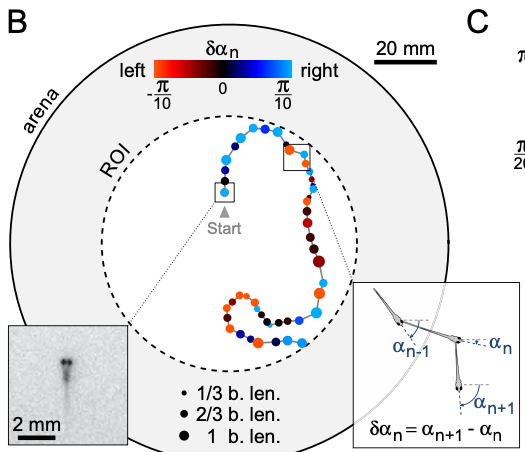

Distribution of bout angles, which decomposes as a mixture of two normal distributions with different amplitudes (given below), corresponding to "Forward" (F) bouts, and "Turning" bouts, for left (L) or right (R). Accordingly, we will below consider the bout angle emission distributions as Gaussian distributions.

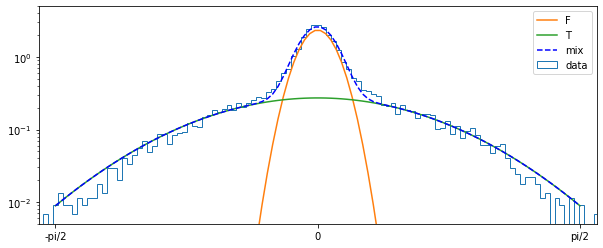

The transition probabilities matrix (rates are probs bc. time is discrete):

$$\begin{aligned}
\Omega &= \begin{pmatrix}
P(F\rightarrow F) & P(L\rightarrow F) & P(R\rightarrow F) \\
P(F\rightarrow L) & P(L\rightarrow L) & P(R\rightarrow L) \\
P(F\rightarrow R) & P(L\rightarrow R) & P(R\rightarrow R) \\
\end{pmatrix} \\
&= \begin{pmatrix}
1 - pturn & 1 - pturn         & 1 - pturn \\
pturn/2   & pturn\,(1-pflip) & pturn\,pflip \\
pturn/2   & pturn\,pflip     & pturn\,(1-pflip) \\
\end{pmatrix}
\end{aligned}$$

where by symmetry considerations (left and right directions are equivalent in an unbiased walk):
$$P(F\rightarrow L) = P(F\rightarrow R) = pturn/2$$
$$P(L\rightarrow R) = P(R\rightarrow L) = pturn\,pflip$$
We also assume that the decision to turn vs. forward bout is independent of the previous state.

To conclude the definition of the HMM, we need to specify how the states determine the probabilities of the bout angles. We assume normal distributions centered at 0. To model left and right bouts, we truncate these distributions to give positive or negative angles only, respectively:

$$E(\delta\alpha|F) = \mathscr{N}(\delta\alpha;\sigma_{F})$$
$$E(\delta\alpha|L) = \begin{cases}
2\mathscr{N}(\delta\alpha;\sigma_{T}) & \delta\alpha > 0 \\
0 & \delta\alpha \le 0
\end{cases}$$
$$E(\delta\alpha|R) = \begin{cases}
2\mathscr{N}(\delta\alpha;\sigma_{T}) & \delta\alpha < 0 \\
0 & \delta\alpha \ge 0
\end{cases}$$

where
$$\mathscr{N}(x;\sigma)=\frac{1}{\sqrt{ 2\pi\sigma^2 }} e^{ -\frac{1}{2}\frac{x^2}{\sigma^2}}$$
is the normal distribution of zero mean.

We will use the following values (determined by Karpenko et al): $\sigma_F=0.1$, $\sigma_T=0.6$, $p_{flip}=0.19$, $p_{turn}=0.41$.

## Questions

1.  plot the emission probabilities of a change of angles (bout angrles y) from - pi/2 to pi/2 given the F,L,R hidden states 
2. Program the Viterbi algorithm to estimate, for one trajectory, the most likely path of hidden states. Start from the most probable value for the hidden variables given the first bout angle.
3. Plot the first  second and third trajectories (`traj_0`, `traj_1`,'traj_2' below) for the bout angles from the data in time, annotating the hidden state inferred by your algorithm for each time step.
4. For each trajectory compute the averages number of consecutive steps spent in each hidden state (sejourn time) and the percentage of time spent in each hidden state.


In [4]:

p_flip = 0.19 # TL -> TR, TR -> TL
p_turn = 0.41
sigma_F = 0.1 # forward bout amplitude
sigma_T = 0.6 # turning bout amplitude

# transition matrix
omega = np.array([
    [1 - p_turn,  1 - p_turn,            1 - p_turn],
    [p_turn/2,    p_turn * (1 - p_flip), p_turn * p_flip],
    [p_turn/2,    p_turn * p_flip,       p_turn * (1 - p_flip)]
  ])

# equilibrium distribution of hidden states
p_eq = np.array([1 - p_turn, p_turn/2, p_turn/2])

In [5]:
#Gaussian

def prob_normal(x, sigma):
  sigma2 = sigma**2
  return np.exp(-x**2 / sigma2 / 2) / np.sqrt(2 * np.pi * sigma2)

In [18]:
# compute emission probabilities from the 3 states, F, L, R
def hmm_emit_probs(data, sigma_F, sigma_T):
  prob_F = prob_normal(data, sigma_F)
  prob_L = np.where(data > 0, prob_normal(data, sigma_T) * 2, 1e-20)
  prob_R = np.where(data < 0, prob_normal(data, sigma_T) * 2, 1e-20)

  # nan data points denote missing measurements
  # We set P(NaN) = 1 for missing data, which means we don't consider these data points
  prob_F = np.where(np.isnan(prob_F), 1, prob_F) #replace Nan occurence with 1
  prob_L = np.where(np.isnan(prob_L), 1, prob_L)
  prob_R = np.where(np.isnan(prob_R), 1, prob_R)

  return np.stack((prob_F, prob_L, prob_R), axis=-1)

In [7]:
# bout delta-angles are the difference between angle at time 't' and at time 't-1'
delta_alphas = alphas_spontaneous[1:,:] - alphas_spontaneous[:-1,:]

# trajectories we will use (used to avoid NaN, time when you can follow the fish), from 0 to 14, 0 to 
traj_0 = delta_alphas[:14,0] 
traj_1 = delta_alphas[:30,1]
traj_2 = delta_alphas[:42,2]

In [8]:
traj_0 

array([-0.05964375, -0.02205352,  0.05464372, -0.27109047,  0.18177256,
        0.189435  , -0.03604658,  0.19053418, -0.0104957 ,  0.03036824,
        0.03001934,  0.1680665 ,  0.44189421, -0.04178945])

1.  Plot the emission probabilities of a change of angles (bout angles y) from - pi/2 to pi/2 given the F,L,R hidden state

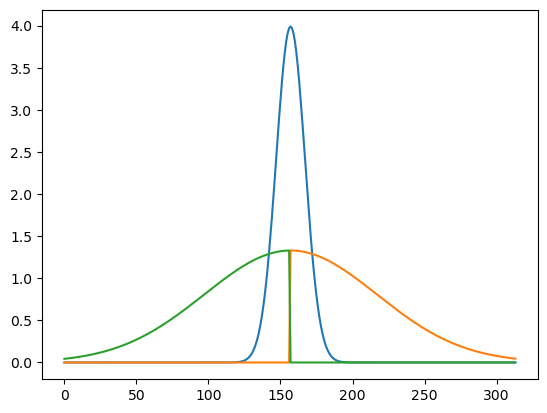

In [9]:
#Plot emission probabilities

#x axis is pi (half under 0 for negative angles, the other half on top of 0 for positive angles)

x = np.arange(-1.57, 1.57, 0.01)
plt.plot(hmm_emit_probs(x, sigma_F, sigma_T) [:,0])
plt.plot(hmm_emit_probs(x, sigma_F, sigma_T) [:,1])
plt.plot(hmm_emit_probs(x, sigma_F, sigma_T) [:,2])

2. Program the Viterbi algorithm to estimate, for one trajectory, the most likely path of hidden states. Start from the most probable value for the hidden variables given the first bout angle.

In [10]:
x_0 = traj_0[0]

#Store three values of x at each time step: matrix of x* dim 3xL (L=number of time steps)

#First move is left
x_0

-0.059643754732445764

In [11]:
def viterbi(data,xin):
    # put here the Viterbi algorithm code
    #Forward Propagation Viterbi Algorithm
    #find x(i) and lp(i) by maximising over the 3 hidden states in i+1
    #value of the loglikelihood maximised over all hidden units except the ith-hidden state
    #initial state the equilibrium distribution for the vp
    
    L=np.size(data) #retrive length og input sequence 'data'
    E=np.zeros((3,L))#initialise matrix E (3,L) to store emission probs
    
    #fill in the matrix with the emission probabilities needed
    E[0,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,0]#front
    E[1,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,1]#left
    E[2,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,2]#right
    

    vp=np.zeros(3) #initialise viterbi probabilities for each state
    #set the initial viterbi probabilities based on the 
    #initial transition matrix omega
    vp[0]=np.log(omega[xin,0]) 
    vp[1]=np.log(omega[xin,1])
    vp[2]=np.log(omega[xin,2])

    #temporary array to stroe updated Viterbi probabilities
    vptmp=np.zeros(3) 

    #initialise a matrix to stor the backpointer 
    #indices for each position and state
    xp=np.zeros((L,3)).astype(int)
    
    #Viterbi recursion
    for i in range (L-1):
        for x in range(3):
            #compute the log-probabilities for each state at the current position
            #based on previous viterbi prob., emission prob., state transition probs.
            lp=vp+np.log(E[:,i])+np.log(omega[x,:])
            #update the temporary array with the maximum log-probability 
            #for each state at the current position
            vptmp[x]=np.amax(lp)
            #store index of state that maximises the log-probability
            xp[i,x]=np.argmax(lp)
        vp=np.copy(vptmp)
    
    #Final log-probability and backtracking
    #compute the overall log-probability of the sequence at the last position
    lp=vp+np.log(E[:,L-1])
    
    #find the max log-probability at the last position
    vplast=np.amax(lp)

    #initialise an array to store the most probable sequence of hidden states
    xf=np.zeros(L).astype(int)

    #most probable hidden variable for the last base
    #store the index of the state that maximises the log-probability at the last position
    xf[L-1]=np.argmax(lp)

    #Backpropagation to find the most probable sequence of hidden states
    #loop iterating backward from the second-to-last position to the first position 
    #updating array 'xf' containing the most probable sequence of hidden states
    for i in range(L-2,-1,-1):
        xf[i]=xp[i,xf[i+1]]


    return xf

In [21]:
viterbi(traj_0,0)

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [12]:
#Distribution of persistence time
def pers_times(xf):
    M=np.size(xf)
    times=np.zeros((3,M))
    times_0=[]
    times_1=[]
    times_2=[]

    k=0
    while (k<M): 
        x=xf[k]
        ki=0
   
        while (not (k+ki == M) and xf[k+ki]==x):
            ki+=1
       
        if(x==0):
            times_0.append(ki)
        elif(x==1):
            times_1.append(ki)
        else:
            times_2.append(ki) 
        k+=ki   
    
    return(np.mean(times_0),np.mean(times_1), np.mean(times_2),np.sum(times_0)/M,np.sum(times_1)/M,np.sum(times_2)/M)

In [22]:
pers_times(xf0)

(4.0, 1.0, 1.0, 0.8571428571428571, 0.07142857142857142, 0.07142857142857142)

In [13]:
#initialise a 1D array that will contain the most lijely initial hidden state
h=np.zeros(3)
h[0]=0 #front
h[1]=1 #left 
h[2]=-1 #right


#find the most probable hidden state for the first emission fix the hodden state 0 
#to ths state
print(hmm_emit_probs(traj_0[0], sigma_F, sigma_T))
print('most prob initial hidden state for traj 0:0')

[3.33935504e+00 1.00000000e-20 1.32325349e+00]
most prob initial hidden state for traj 0:0


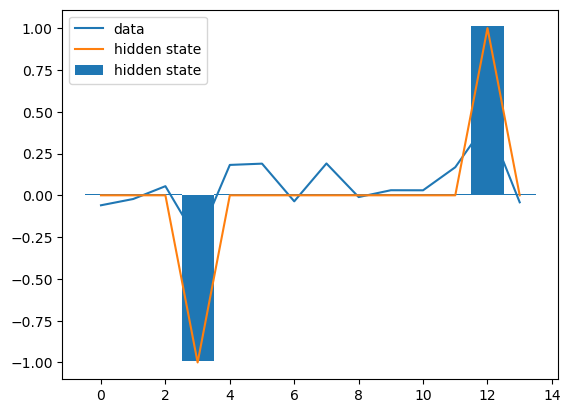

In [14]:
#plot of the inferred hidden states (14) by the Viterbi algorithm compared to real data


xf0=viterbi(traj_0,0)
x=np.arange(np.size(traj_0))
plt.plot(traj_0,label='data')
plt.bar(x,h[xf0]+0.01,width=1,label='hidden state')
plt.plot(x,h[xf0],label='hidden state')
plt.legend()
#here 0,1,2 correspond to the hidden states F,L,R

In [29]:
[pers_0,pers_1,pers_2,p_0,p_1,p_2]=pers_times(xf0)
print('persistence times',pers_0,pers_1,pers_2)
print('probability',p_0,p_1,p_2)

persistence times 4.0 1.0 1.0
probability 0.8571428571428571 0.07142857142857142 0.07142857142857142


3. Plot the first  second and third trajectories (`traj_0`, `traj_1`,'traj_2' below) bout angles from the data in time, annotating the hidden state inferred by your algorithm for each time step.

In [15]:
#find the most probable hidden state for the first emission fix the hodden state 0 
#to ths state
print(hmm_emit_probs(traj_1[0], sigma_F, sigma_T))
print('most prob initial hidden state for traj 1:0')

[3.22781519e+00 1.00000000e-20 1.32200536e+00]
most prob initial hidden state for traj 1:0


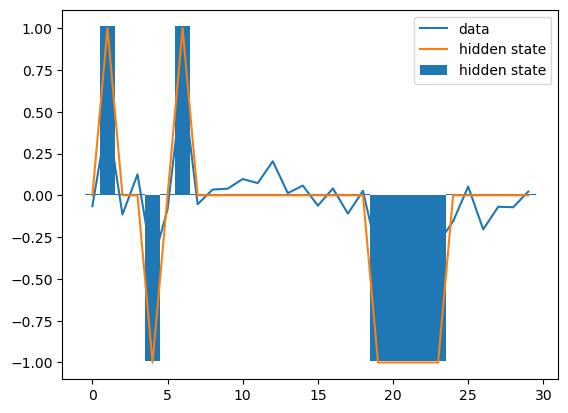

In [16]:
x=np.arange(np.size(traj_1))
xf1=viterbi(traj_1,0)
plt.plot(traj_1,label='data')
plt.plot(h[xf1],label='hidden state')
alpha=20
plt.bar(x,h[xf1]+0.01,width=1,label='hidden state')
#here 0,1,2 correspond to the hidden states F,L,R
plt.legend()
plt.show()
